In [2]:
# -------- Autogenerated code --------
# modifications to this cell will be overwritten

# Import CSV data into a pandas data frame: 
# see also: http://pandas.pydata.org/
import pandas
csv_file = None
with open('wonambi-inputs/csv_file', 'r') as csv_input:
    csv_file = pandas.read_csv(csv_input, error_bad_lines=False)


## Tessellation Tester Notebook

This iPython Notebook is for CSIRO staff to experiment the use of the wavelet tesellation method on their own data sets.

Each time you start the notebook with a new data set you should restart the kernel using __Restart__ on the __Kernel__ the menu. 

You can make copies of the notebook if you want to keep different versions.

To run a cell, place your cursor in the cell and press [SHIFT] [ENTER], or use the __Cell__ menu

In a new folder:
 - add the iPython Notebook
 - add the python_files folder
 - add your input data file (as csv)
 - place your input data into a new folder called __inputfiles__
 - make a new folder to save output images called __outputfiles__




Import the required python libraries.

In [3]:
%pylab inline
import pandas
import numpy
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys

/root/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


Import the python files for data preparation, wavelet transform, tessellation and plotting.

In [4]:
from tessellation import data_prep_test as data_prep
from tessellation import dogcwt_test as dogcwt
from tessellation import tess_test as tess
from tessellation import tess_plot3_test as tplot3

Import some data

- your data should be in a folder, you need to provide the relative location to the folder as __inputFolder__
- you also need a folder for output data, you need to provide the relative location to the folder as __outputFolder__
- finally you need to provide the name of the file in csv format, this is __dataFile__

The column headers will be printed out

In [5]:
outputFolder = "wonambi-outputs/"
data = csv_file # The value of csv_file will be set to a Pandas DataFrame by Wonambi.
print numpy.asarray(data.keys()) # print out the column headers

['Drillhole Name' 'Depth From' 'Depth To' 'Check' 'Mg_ppm' 'Al_ppm'
 'Si_ppm' 'P_ppm' 'S_ppm' 'K_ppm' 'Ca_ppm' 'Ti_ppm' 'V_ppm' 'Cr_ppm'
 'Mn_ppm' 'Fe_ppm' 'Co_ppm' 'Ni_ppm' 'Cu_ppm' 'Zn_ppm' 'As_ppm' 'Se_ppm'
 'Rb_ppm' 'Sr_ppm' 'Y_ppm' 'Zr_ppm' 'Nb_ppm' 'Mo_ppm' 'Ag_ppm' 'Cd_ppm'
 'Sn_ppm' 'Sb_ppm' 'W_ppm' 'Hg_ppm' 'Pb_ppm' 'Bi_ppm' 'Th_ppm' 'U_ppm'
 'Le_ppm']


Select the column that you wish to analyse by name

## Data Preparation

Choose one of the variables to tessellate by using the column name.

In [6]:
values = data['Sr_ppm'] # change for your data

Set the depths:
- if this is point data then choose the depth column
- if this is interval data then take the midpoints of the "from" and "to" depths

In [7]:
### EITHER:
#depths = numpy.asarray(data['Depth']) # change for your data file
### OR:
from_depths = numpy.asarray(data['Depth From']) # change for your data file
to_depths = numpy.asarray(data['Depth To']) # change for your data file
depths = (from_depths + to_depths) / 2.

Test the data to see if it has been sampled at a regular spacing

Note: This version I have supplied does not handle large gaps in the data values

In [8]:
data_prep.regular_samples(depths)

median spacing is 1.0
maximum spacing is 19.5


False

check that depth intervals are all positive

In [9]:
if any(diff(depths) <= 0):
    print 'invalid depths'
else: print 'depths OK'

depths OK


If the spacing is not regular (i.e. data_prep.regular_samples(depths) returns "False"), then data must be regularised prior to the wavelet transform

Plots:

- The plots show the original data in red and the interpolated data in black. 

- The interpolation results in some smoothing of the original data.

- Both plots show the same information, but the upper plot is a line plot and the lower plot is a point plot.

median spacing is 1.0
maximum spacing is 19.5


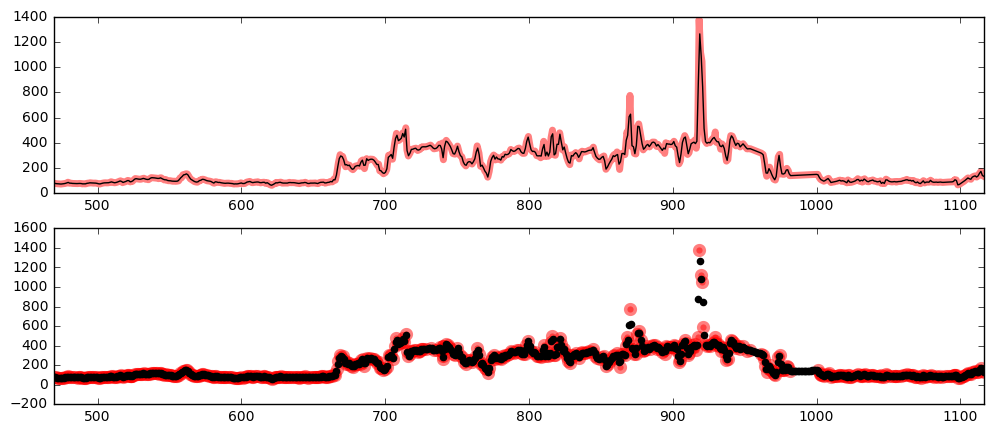

In [10]:
if not data_prep.regular_samples(depths):
    rdepths,rvalues = data_prep.regularise_data(depths,values)
    data_prep.plot_regularised_data(depths,rdepths,values,rvalues)

## Wavelet Transform

Create a second order DOG wavelet transform, __dog2__
- retrieve the wavelet coefficient values, __coeff2__
- retrieve the scales at which the transform was calculated, __scales__

In [11]:
dog2 = dogcwt.DOGCWT(rvalues,rdepths, 2)
coeff2 = dog2.get_coeff()
scales = dog2.get_scales()

### ignore warnings about casting complex values to reals

/root/anaconda3/envs/py2/lib/python2.7/site-packages/tessellation/dogcwt_test.py:163: ComplexWarning: Casting complex values to real discards the imaginary part
  padded_dog_coeff[i] = ifft(wti)


## Tessellation

Create the tessellation object, __tess2__
- Calculate the mean values for each rectangle, __tess2_means__
- Retrieve the tessellation rectangles, __tess2t__

In [12]:
tess2 = tess.Tess(rvalues,rdepths,scales,coeff2)
tess2_means = tess2.tessellation_signal_means(values=values,vdepths=depths)
tess2t = tess2.tessellation

Filter the tessellation:

The amount to filter by is expressed as a percentage in the filter_middle_child() function.
Higher values result in stronger filtering.

- new filtered tessellation object, __tess2_f__
- mean values for each rectangle, __tess2_f_means__
- rectangles for filtered tessellation, __tess2tf__

In [13]:
filter_tess2 = tess2.filter_middle_child(48) #modify filter percentage here, initially 40%
tess2_f = tess.Tess(rvalues,rdepths,scales,coeff2,filter_tess2)
tess2_f_means = tess2_f.tessellation_signal_means()
tess2tf = tess2_f.tessellation

Plot wavelet transform, tessellation and filtered tessellation

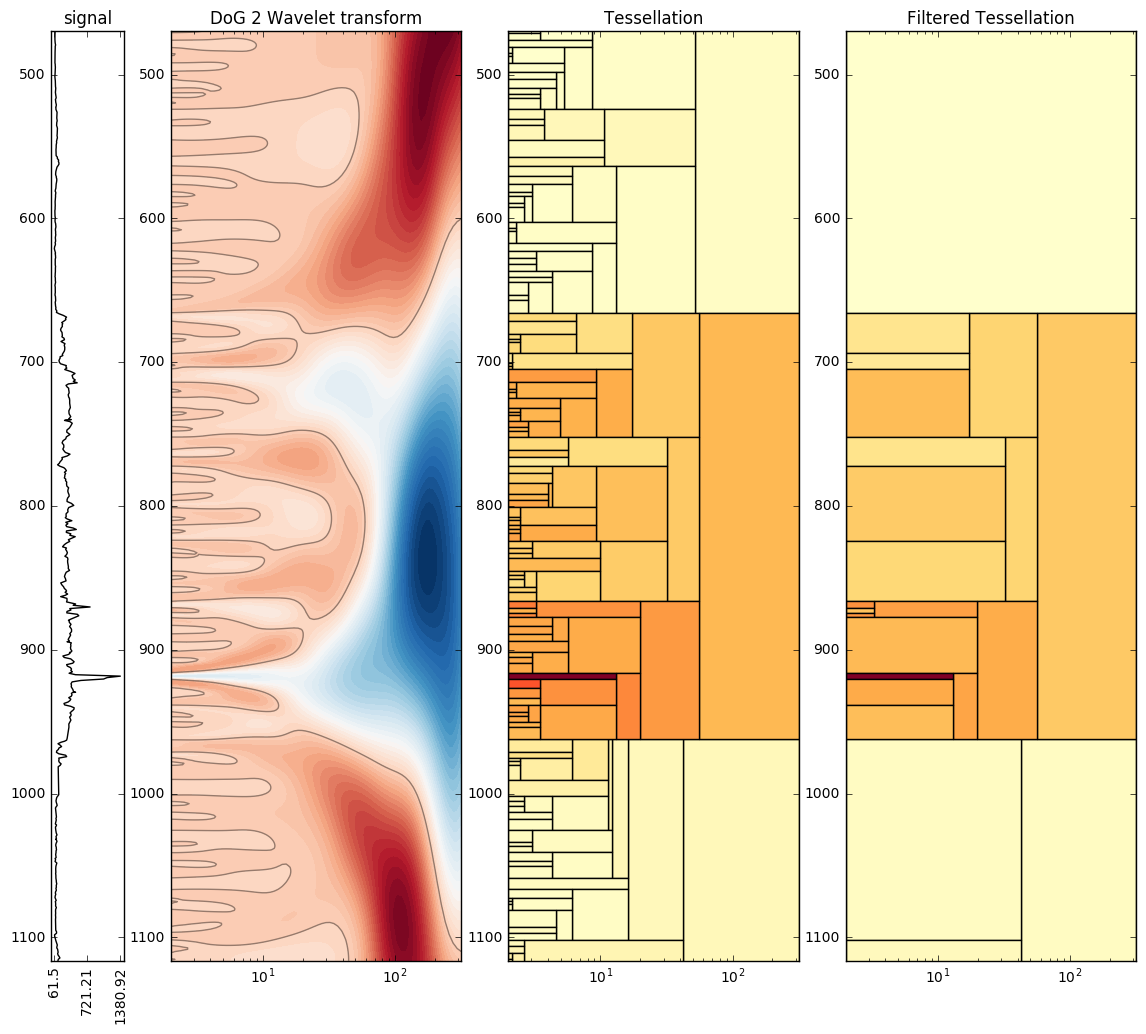

In [15]:
tplot_1 = tplot3.TessPlot3(values,depths,height=12) # you can adjust the height of the plot here
ax0,ax1,ax2,ax3 = tplot_1.get_axs()

tplot_1.wav_coeffs_first(ax1,coeff2,scales,rdepths,cmap='RdBu_r')
tplot_1.add_contour(ax1,coeff2,scales,rdepths)
ax1.set_title('DoG 2 Wavelet transform')

tplot_1.tess_first(ax2,tess2t,fillcol=tess2_means,cmap='YlOrRd')
ax2.set_title('Tessellation')

tplot_1.tess_first(ax3,tess2tf,fillcol=tess2_f_means,cmap='YlOrRd')
ax3.set_title('Filtered Tessellation')


In [16]:
### Save the figure to a png file
figName = 'Test_Brukunga1_DoG2.png'
tplot_1.get_fig().savefig(outputFolder+figName)